In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns
import fastf1 as f1
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [2]:
f1.Cache.offline_mode(True)

req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) C:\Users\amanh\AppData\Local\Temp\fastf1


In [3]:

f1.Cache.enable_cache("D:\\Aman\\f1_analytics\\cache")
race=f1.get_session(2024,'Monza','Race')
race.load()
pd.DataFrame(race.laps).to_csv("monza_2024.csv", index=False)

core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']


In [4]:
qatar_csv=pd.read_csv("monza_2024.csv")

In [5]:
def cleanLapTime(x):
    if pd.isna(x):
        return np.nan
    else:
        time_part=x.split("days")[1].strip()
        time_obj = timedelta(hours=int(time_part[:2]), 
                        minutes=int(time_part[3:5]), 
                        seconds=int(time_part[6:8]), 
                        microseconds=int(time_part[9:]) if '.' in time_part else 1000)

        # Convert timedelta to a datetime object (only time part)
        time_only = (datetime.min + time_obj).time()

        # Formatting as HH:MM:SS.MS
        formatted_time = time_only.strftime("%H:%M:%S.%f")[:-3]
    return formatted_time

In [6]:
def replaceNaN(x):
    return x.ffill().bfill()

In [7]:
qatar_csv["LapTime"]=qatar_csv["LapTime"].apply(cleanLapTime)
qatar_csv.LapTime=qatar_csv.LapTime.astype('string')
qatar_csv["LapTime"]=pd.to_datetime(qatar_csv["LapTime"], format="%H:%M:%S.%f")
qatar_csv["LapTime"]=qatar_csv.groupby("Driver")["LapTime"].transform(replaceNaN)
qatar_csv["LapTime"]=qatar_csv["LapTime"].fillna(0)

In [8]:
highLapDriver=qatar_csv[qatar_csv["Driver"]=="LEC"]["LapNumber"]
print(highLapDriver.max())
print(qatar_csv["Driver"].unique())
print(qatar_csv.groupby(by=["Driver"])["LapNumber"].max())
for driver in qatar_csv["Driver"].unique():
    lapsCompleted=qatar_csv[qatar_csv["Driver"]==driver]["LapNumber"]
    print(f"Driver {driver}, laps completed {lapsCompleted.max()}")

53.0
['LEC' 'PIA' 'NOR' 'SAI' 'HAM' 'VER' 'RUS' 'PER' 'ALB' 'MAG' 'ALO' 'COL'
 'RIC' 'OCO' 'GAS' 'BOT' 'HUL' 'ZHO' 'STR' 'TSU']
Driver
ALB    53.0
ALO    53.0
BOT    52.0
COL    53.0
GAS    52.0
HAM    53.0
HUL    52.0
LEC    53.0
MAG    53.0
NOR    53.0
OCO    52.0
PER    53.0
PIA    53.0
RIC    53.0
RUS    53.0
SAI    53.0
STR    52.0
TSU     7.0
VER    53.0
ZHO    52.0
Name: LapNumber, dtype: float64
Driver LEC, laps completed 53.0
Driver PIA, laps completed 53.0
Driver NOR, laps completed 53.0
Driver SAI, laps completed 53.0
Driver HAM, laps completed 53.0
Driver VER, laps completed 53.0
Driver RUS, laps completed 53.0
Driver PER, laps completed 53.0
Driver ALB, laps completed 53.0
Driver MAG, laps completed 53.0
Driver ALO, laps completed 53.0
Driver COL, laps completed 53.0
Driver RIC, laps completed 53.0
Driver OCO, laps completed 52.0
Driver GAS, laps completed 52.0
Driver BOT, laps completed 52.0
Driver HUL, laps completed 52.0
Driver ZHO, laps completed 52.0
Driver STR, laps 

In [9]:
result=qatar_csv.groupby(by=["Driver"])["Position"].last().sort_values()
lastFinishers=result[result<4].index.to_list()
lastFinishers=[a for a in lastFinishers if a not in {"HUL","STR"}]

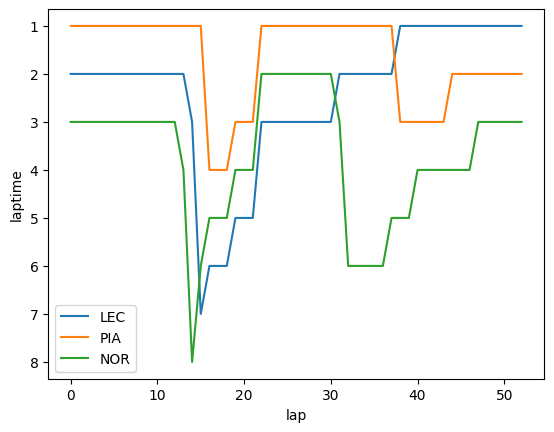

In [10]:
_,b=plt.subplots()
for driver in lastFinishers:
    b.plot(list(range(len(qatar_csv[qatar_csv["Driver"]==driver]["Position"].to_list()))), qatar_csv[qatar_csv["Driver"]==driver]["Position"].to_list(),label=driver)
b.set_ylabel("laptime")
b.set_xlabel("lap")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

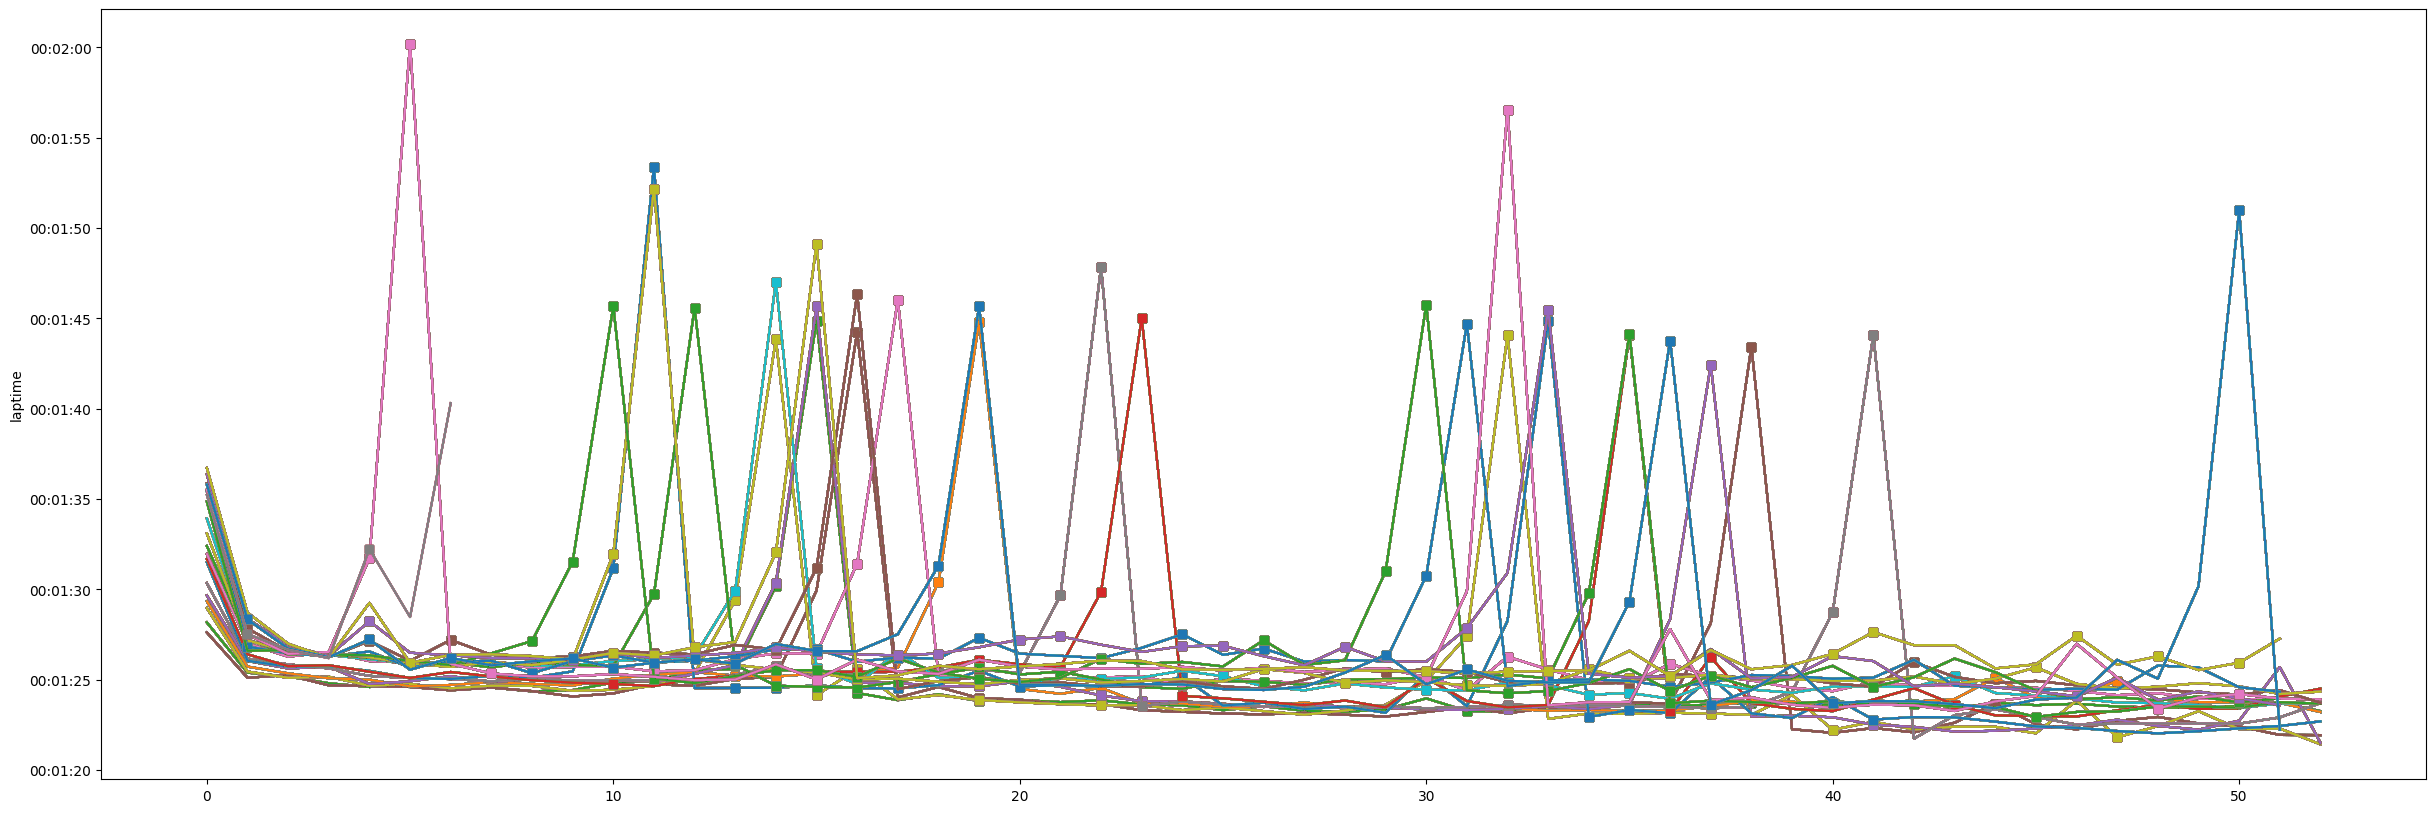

In [11]:
markevery=[]
fig, ax=plt.subplots(figsize=(30, 10))
drivers=qatar_csv["Driver"].to_list()
for driver in drivers:
    driverPosition=qatar_csv[qatar_csv["Driver"]==driver]["Position"].to_list()
    for i in range(1,len(driverPosition)):
        if driverPosition[i]-driverPosition[i-1]!=0:
            markevery.append(i)
    ax.plot(list(range(len(qatar_csv[qatar_csv["Driver"]==driver]["LapTime"].to_list()))), qatar_csv[qatar_csv["Driver"]==driver]["LapTime"].to_list(), markevery=markevery,marker="s")
    markevery=[]
ax.set_ylabel("laptime")
plt.show()

In [12]:
max_laps=qatar_csv["Driver"].value_counts().max()
qatar_csv["Finished"]=qatar_csv.groupby("Driver")["Driver"].transform(lambda x:x.count()==max_laps)

In [13]:
qatar_csv["PitLap"]=qatar_csv.groupby("Driver")["Stint"].transform(lambda x:x.ne(x.shift(-1).ffill()) if len(x)>1 else False)
def pitLaps(x):
    x=x.reset_index(drop=True)
    return x[x].index.to_list()
result=qatar_csv.groupby(by=["Driver"])["Position"].last().sort_values()
lastFinishers=result[result>0].index.to_list()
lastFinishers=[a for a in lastFinishers if a not in {"HUL","STR","PER"}]

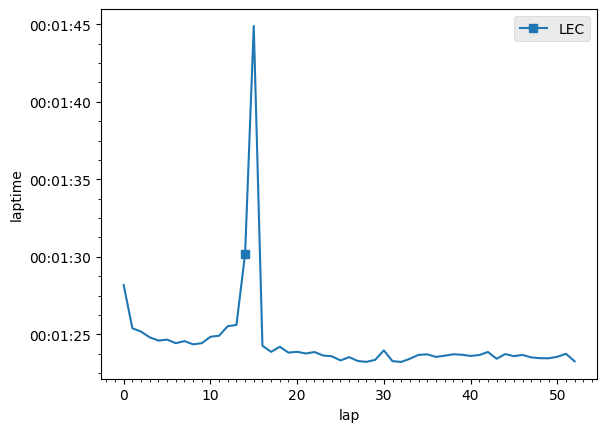

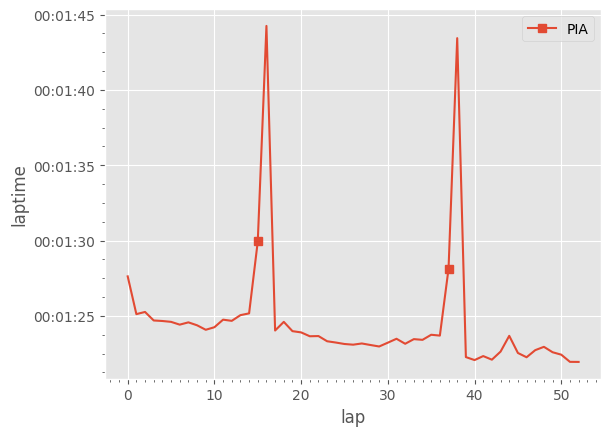

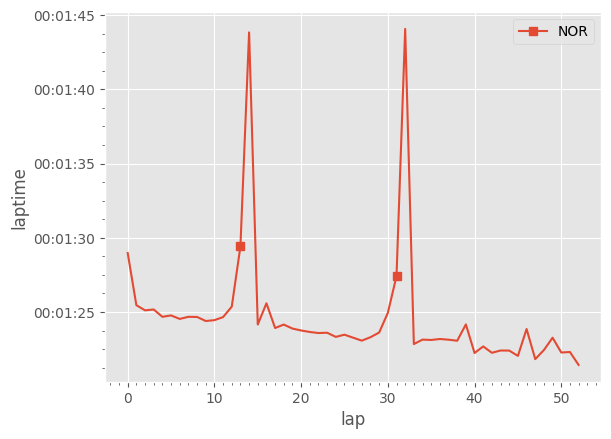

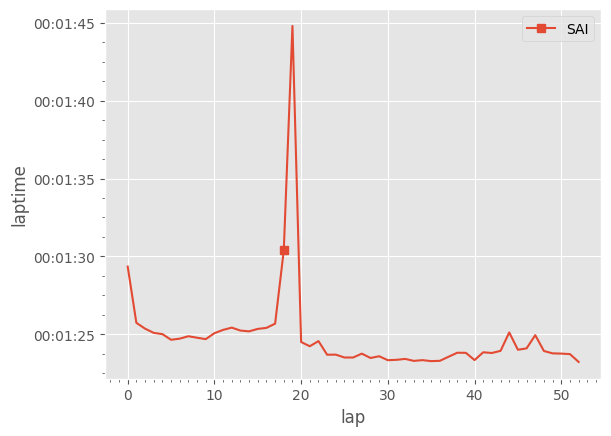

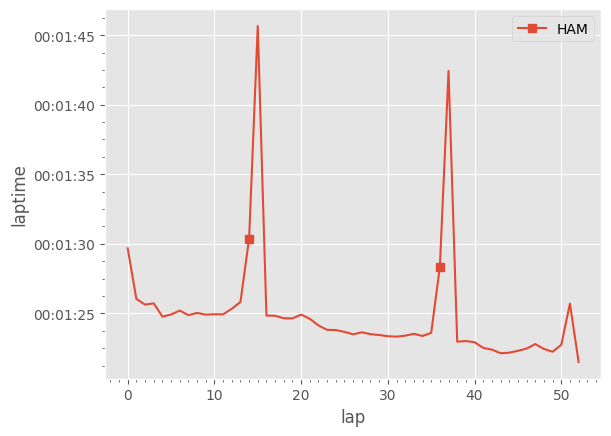

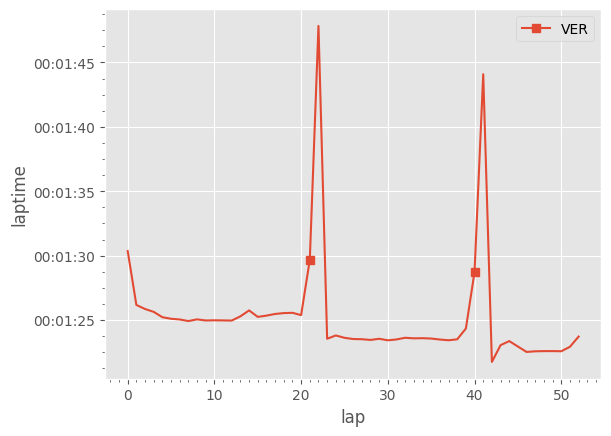

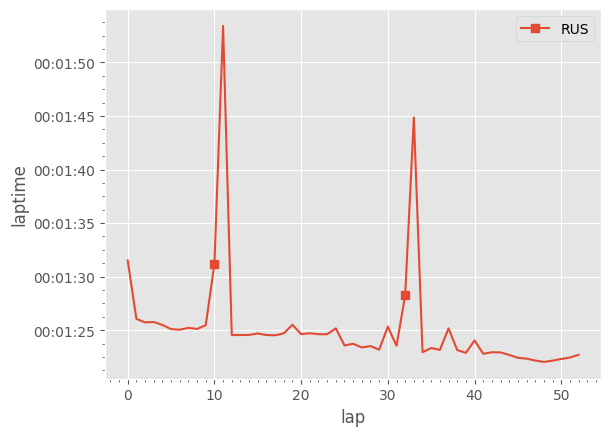

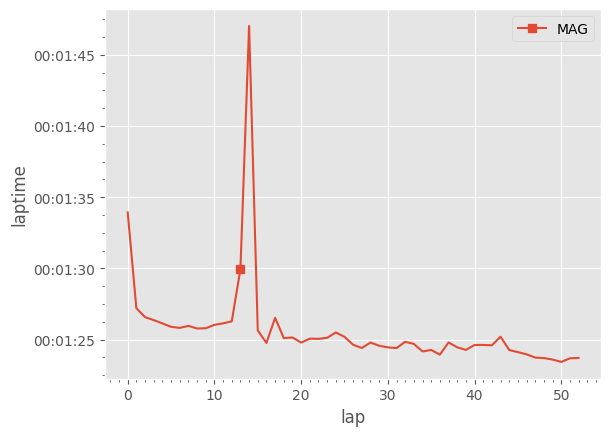

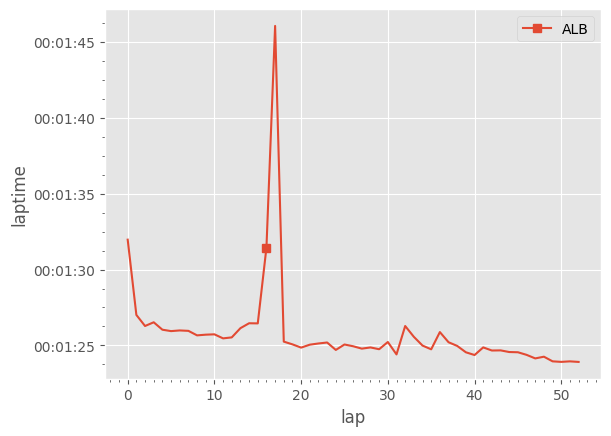

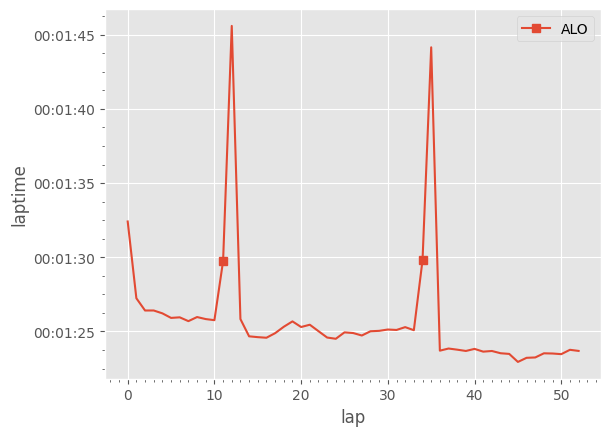

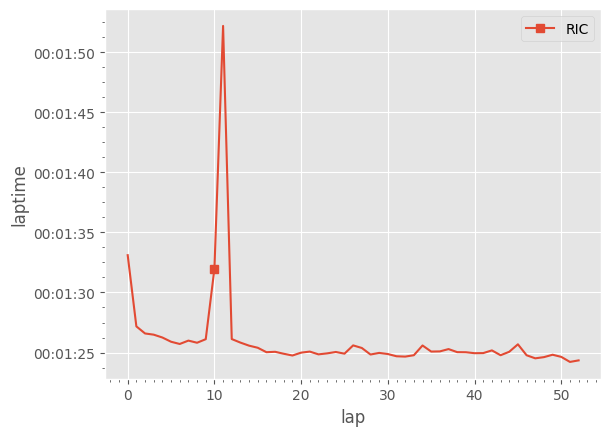

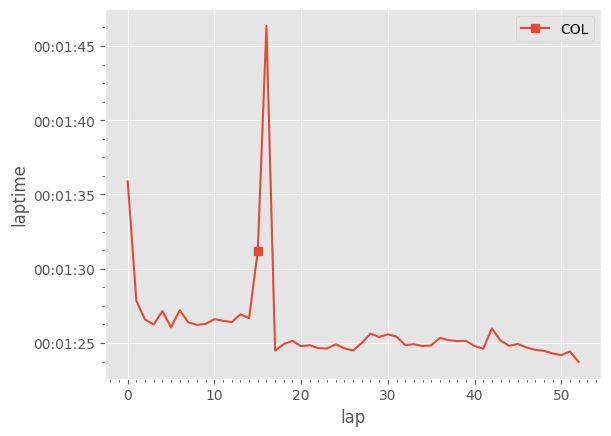

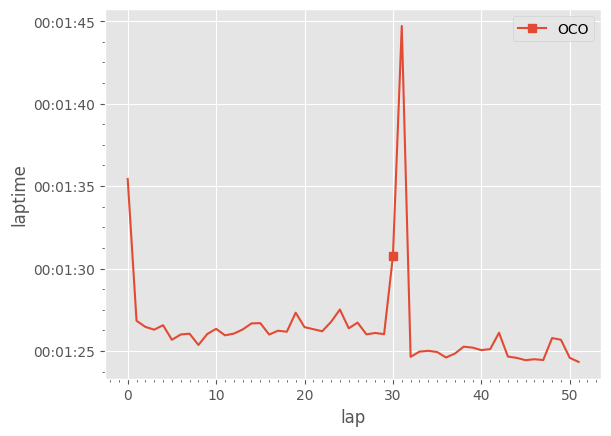

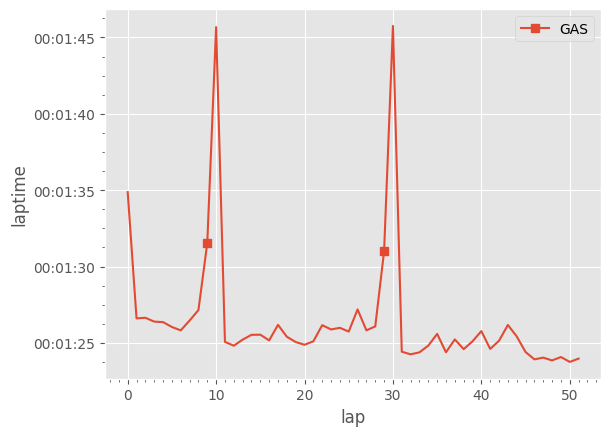

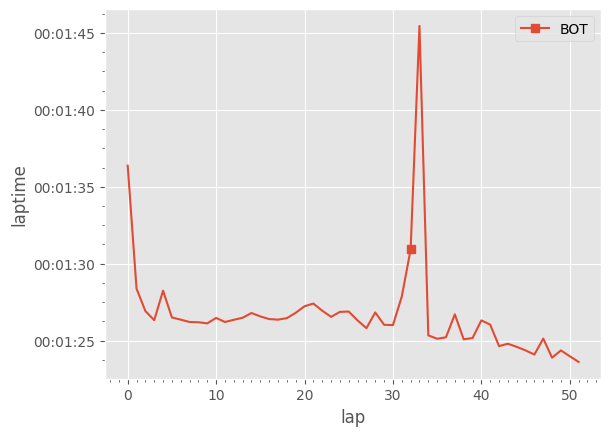

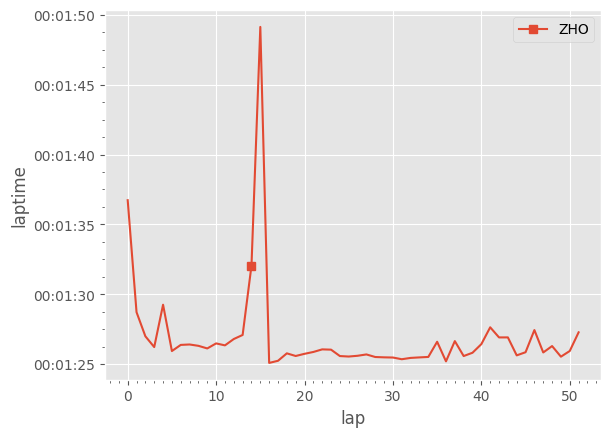

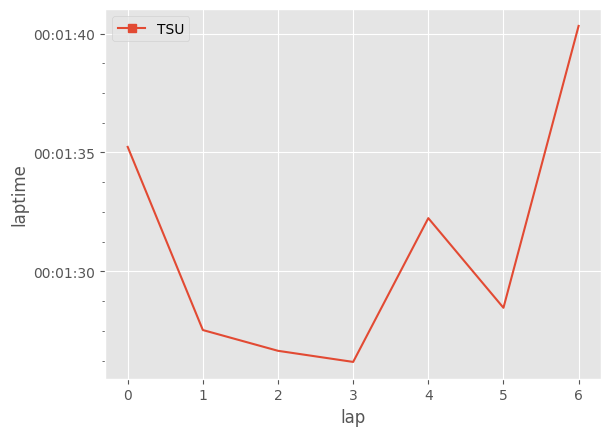

In [14]:
for driver in lastFinishers:
    _,b=plt.subplots()
    markevery=pitLaps(qatar_csv[qatar_csv["Driver"]==driver]["PitLap"])
    b.plot(list(range(len(qatar_csv[qatar_csv["Driver"]==driver]["LapTime"].to_list()))), qatar_csv[qatar_csv["Driver"]==driver]["LapTime"].to_list(),label=driver, markevery=markevery, marker="s")
    b.set_ylabel("laptime")
    b.set_xlabel("lap")
    plt.minorticks_on()
    b.xaxis.set_minor_locator(MultipleLocator(1))
    plt.style.use('ggplot')
    plt.legend()
    plt.show()

In [15]:
badLapsBeforePitstop=qatar_csv.groupby(by=["Driver", "Stint"])["IsPersonalBest"].apply(lambda x: x[::-1].reset_index(drop=True).idxmax())
maxStint=int(qatar_csv["Stint"].max())
for stint in range(1, maxStint):
    drivers=qatar_csv[qatar_csv["Stint"]==stint+1]["Driver"].unique()
    badLaps=badLapsBeforePitstop.loc[drivers].xs(stint,level="Stint")
    print(f"After {stint} pit stops, drivers had and average bad lap {badLaps.mean()}, upper bound {badLaps.mean()+1.2*badLaps.std()}, lower bound {badLaps.mean()-1.2*badLaps.std()}")

After 1 pit stops, drivers had and average bad lap 7.894736842105263, upper bound 13.95964886906302, lower bound 1.8298248151475063
After 2 pit stops, drivers had and average bad lap 8.7, upper bound 15.536373307536678, lower bound 1.8636266924633205
After 3 pit stops, drivers had and average bad lap 5.0, upper bound nan, lower bound nan


In [16]:
def cleanLapTime(x):
    time_part = x.split("days")[1].strip()
    time_obj = timedelta(hours=int(time_part[:2]), 
                         minutes=int(time_part[3:5]), 
                         seconds=int(time_part[6:8]), 
                         microseconds=int(time_part[9:]) if '.' in time_part else 0)
    return time_obj

[32.713, 30.598, 30.238, 29.802, 30.569, 29.362, 29.885, 29.618, 29.555, 29.706, 29.614, 29.617, 29.546, 29.857, 29.739, 29.78]
LEC [15]


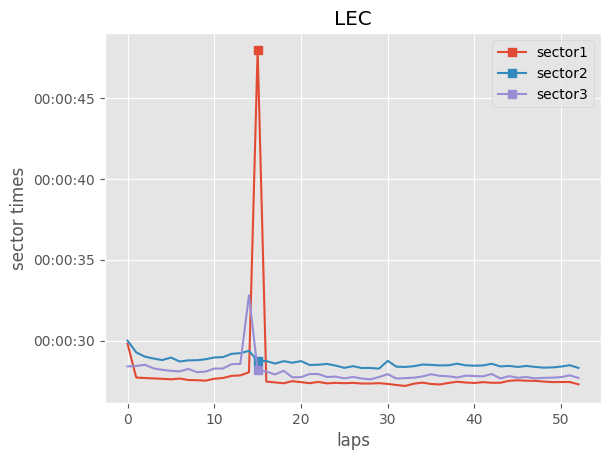

PIA [16, 38]


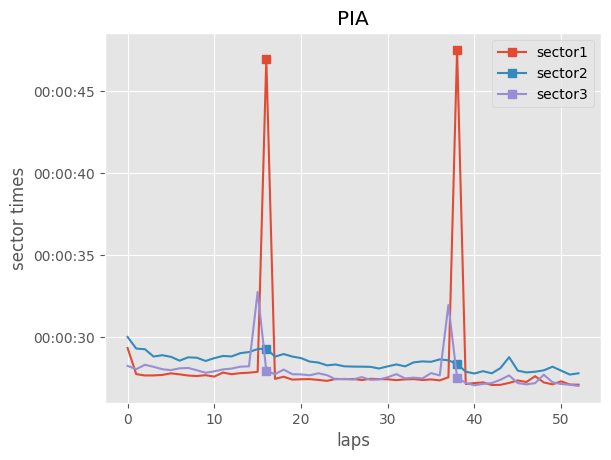

NOR [14, 32]


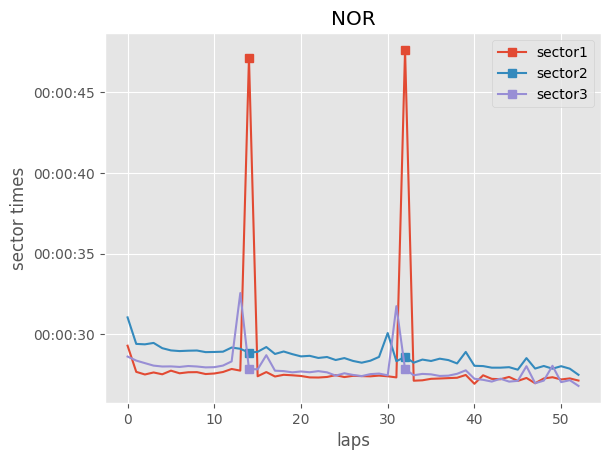

SAI [19]


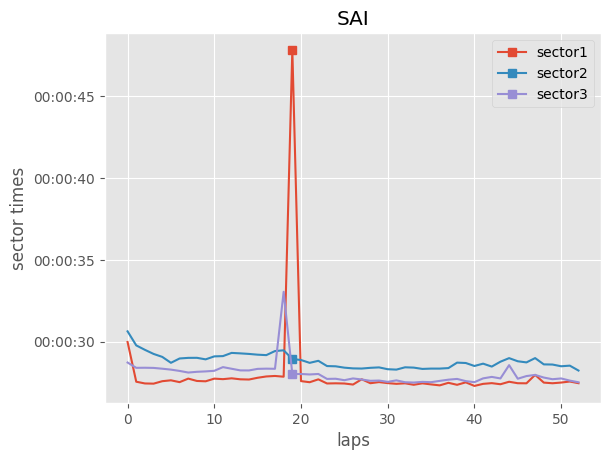

HAM [15, 37]


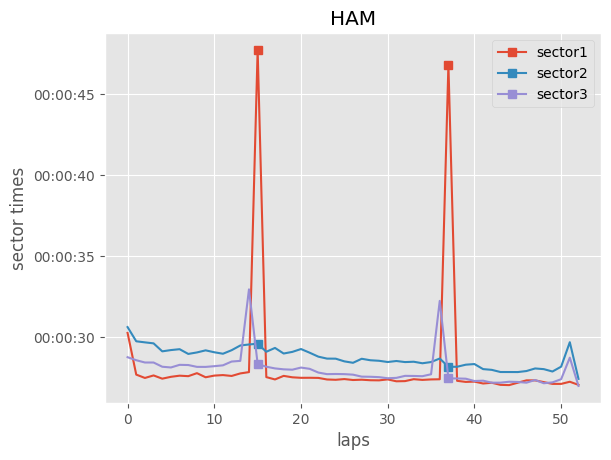

VER [22, 41]


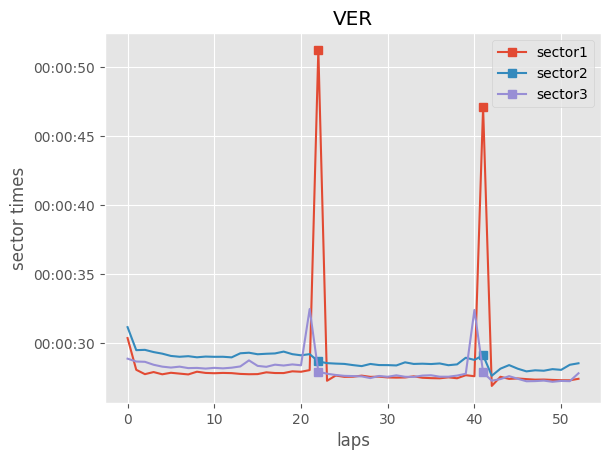

RUS [11, 33]


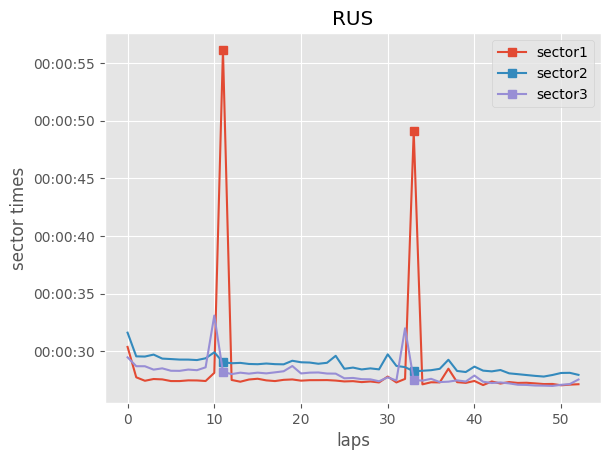

PER [23, 35]


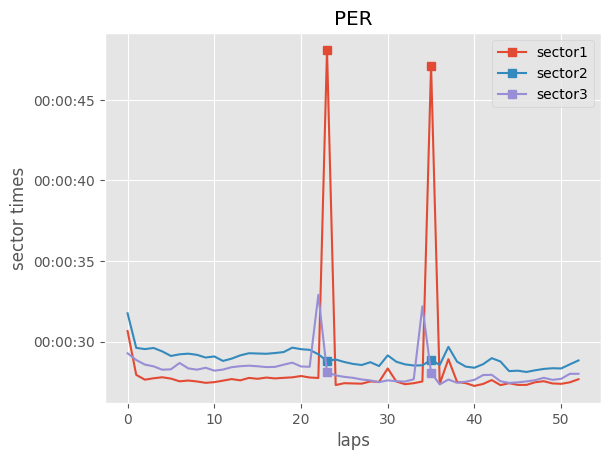

ALB [17]


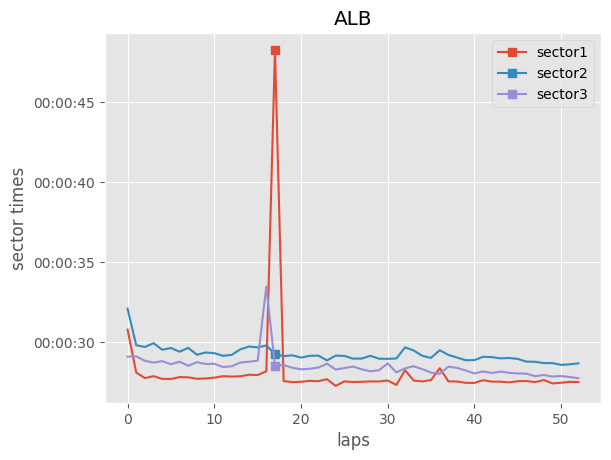

MAG [14]


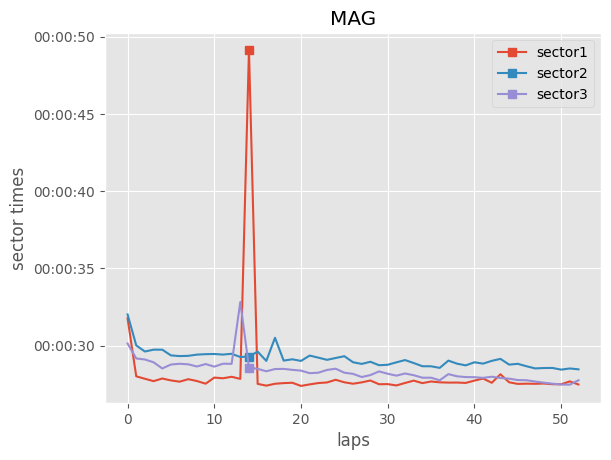

ALO [12, 35]


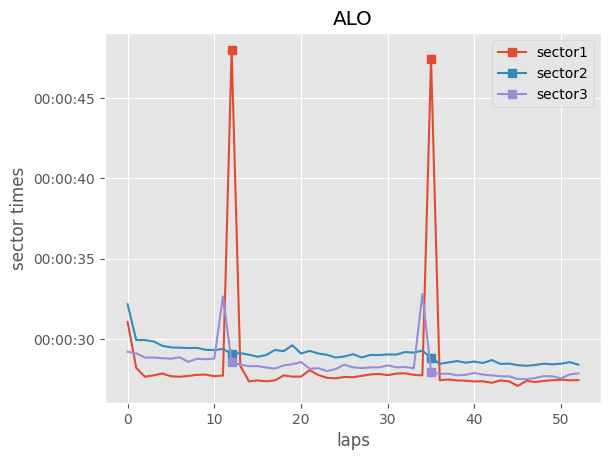

COL [16]


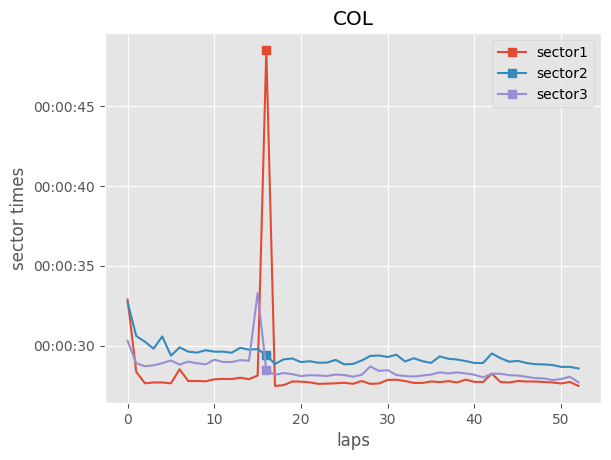

RIC [11]


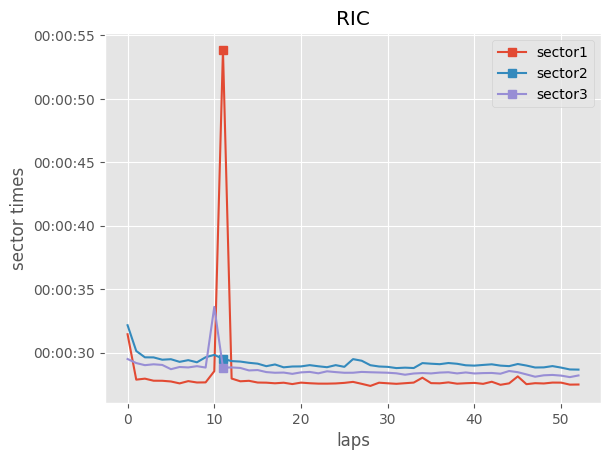

OCO [31]


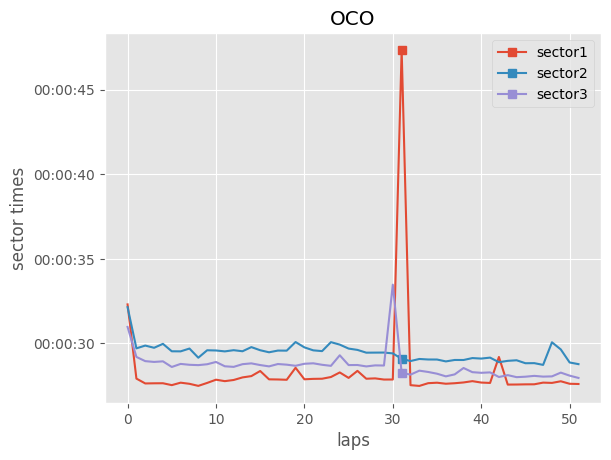

GAS [10, 30]


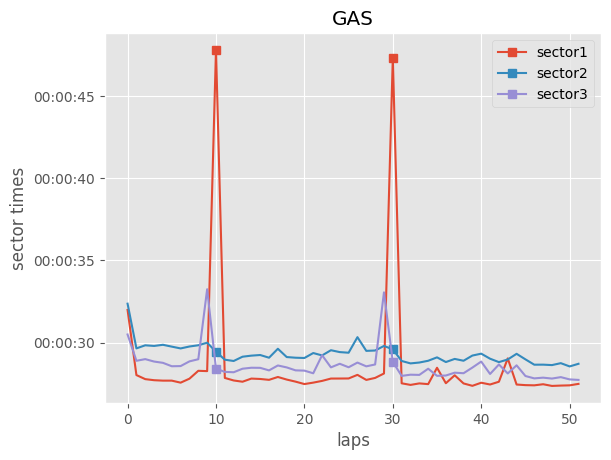

BOT [33]


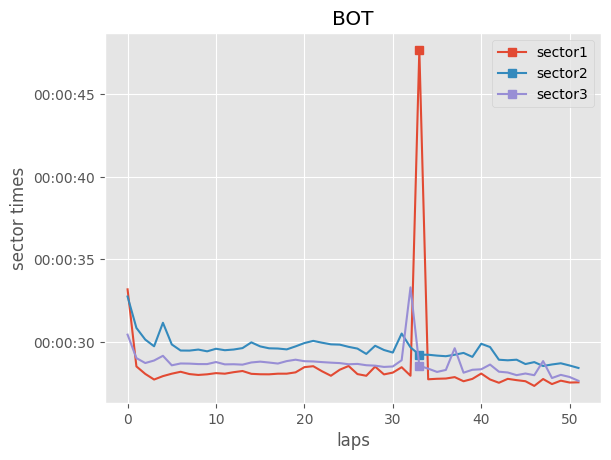

HUL [5, 32]


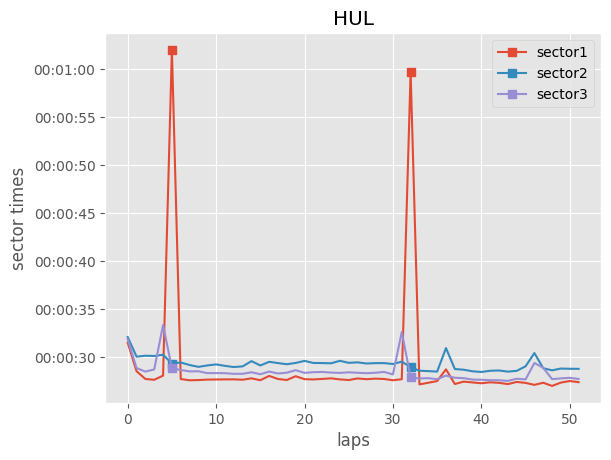

ZHO [15]


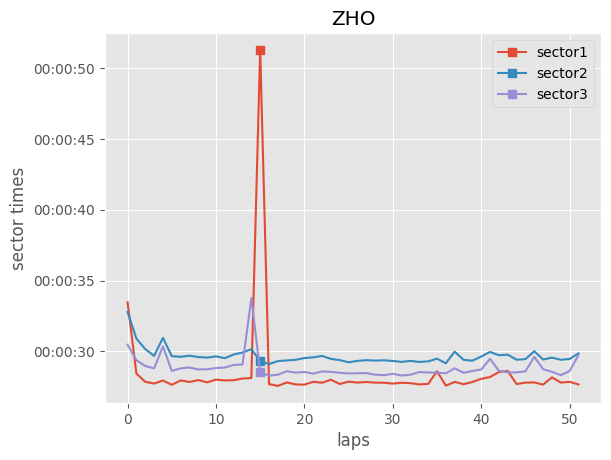

STR [19, 36, 50]


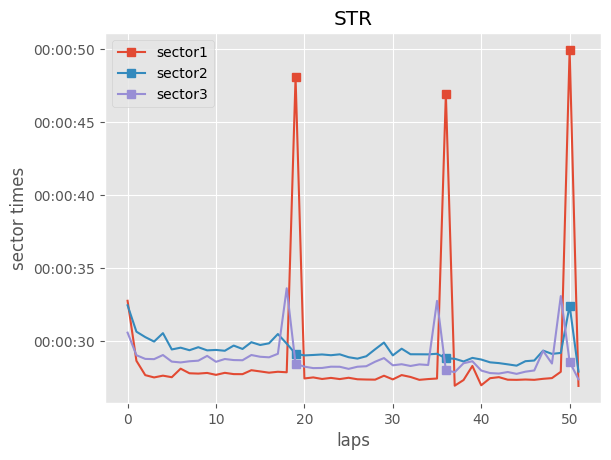

TSU []


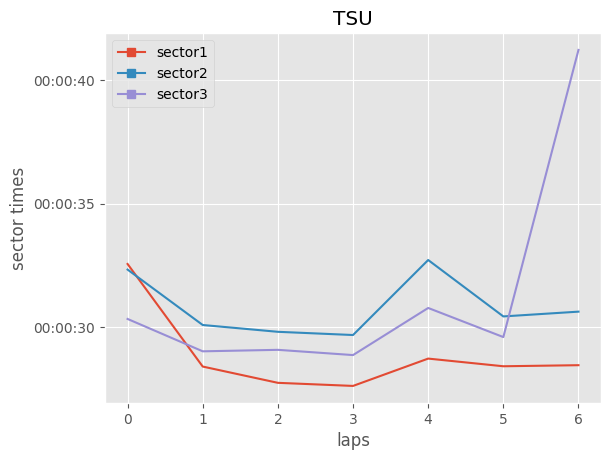

In [17]:
qatar_csv=pd.read_csv("monza_2024.csv")
qatar_csv.loc[:, "LapTime"] = qatar_csv["LapTime"].apply(cleanLapTime)
qatar_csv.loc[:, "Sector2Time"] = qatar_csv["Sector2Time"].apply(cleanLapTime)
qatar_csv.loc[:, "Sector3Time"] = qatar_csv["Sector3Time"].apply(cleanLapTime)
qatar_csv.loc[:,"Sector1Time"]=qatar_csv["Sector1Time"].fillna(qatar_csv["LapTime"]-(qatar_csv["Sector2Time"]+qatar_csv["Sector3Time"]))
qatar_csv["LapTime"] = pd.to_timedelta(qatar_csv["LapTime"])+pd.Timestamp("1900-01-01")
qatar_csv["Sector1Time"] = pd.to_timedelta(qatar_csv["Sector1Time"])+pd.Timestamp("1900-01-01")
qatar_csv["Sector2Time"] = pd.to_timedelta(qatar_csv["Sector2Time"])+pd.Timestamp("1900-01-01")
qatar_csv["Sector3Time"] = pd.to_timedelta(qatar_csv["Sector3Time"])+pd.Timestamp("1900-01-01")
drivers=qatar_csv["Driver"].unique()
qatar_csv["Sector1"]=qatar_csv["Sector1Time"].dt.second+qatar_csv["Sector1Time"].dt.microsecond/1e6
qatar_csv["Sector2"]=qatar_csv["Sector2Time"].dt.second+qatar_csv["Sector2Time"].dt.microsecond/1e6
qatar_csv["Sector3"]=qatar_csv["Sector3Time"].dt.second+qatar_csv["Sector3Time"].dt.microsecond/1e6
print(qatar_csv.loc[qatar_csv["Driver"]=="COL"]["Sector2"].to_list()[:16])
for driver in drivers:
    _,b=plt.subplots()
    markevery=qatar_csv[qatar_csv["Driver"]==driver]["Stint"].value_counts(sort=False).cumsum().to_list()[:-1]
    print(driver,markevery)
    b.plot(list(range(len(qatar_csv[qatar_csv["Driver"]==driver]["LapTime"].to_list()))), qatar_csv[qatar_csv["Driver"]==driver]["Sector1Time"].to_list(),markevery=markevery,marker="s",label="sector1")
    b.plot(list(range(len(qatar_csv[qatar_csv["Driver"]==driver]["LapTime"].to_list()))), qatar_csv[qatar_csv["Driver"]==driver]["Sector2Time"].to_list(),markevery=markevery,marker="s",label="sector2")
    b.plot(list(range(len(qatar_csv[qatar_csv["Driver"]==driver]["LapTime"].to_list()))), qatar_csv[qatar_csv["Driver"]==driver]["Sector3Time"].to_list(),markevery=markevery,marker="s",label="sector3")
    b.set_ylabel("sector times")
    b.set_xlabel("laps")
    plt.title(driver)
    plt.legend()
    plt.show()

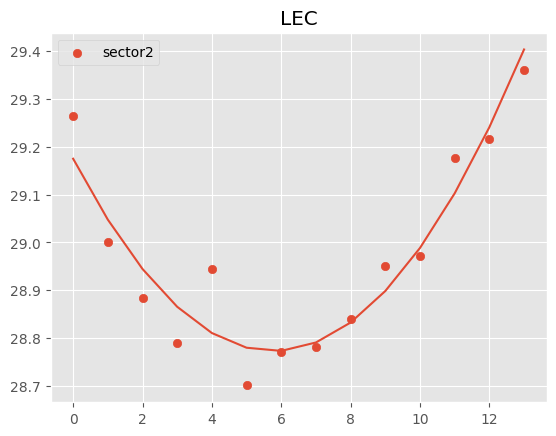

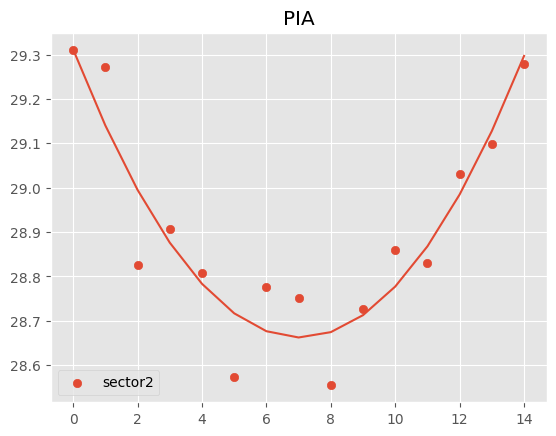

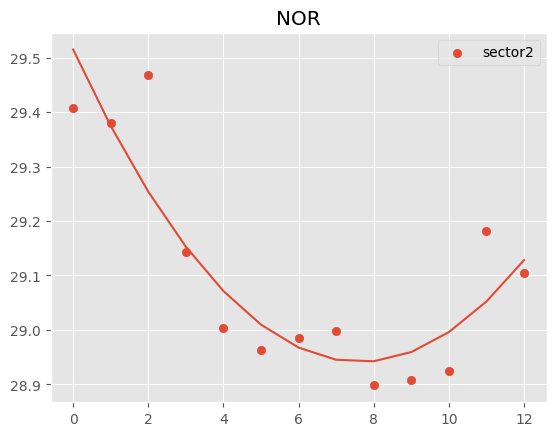

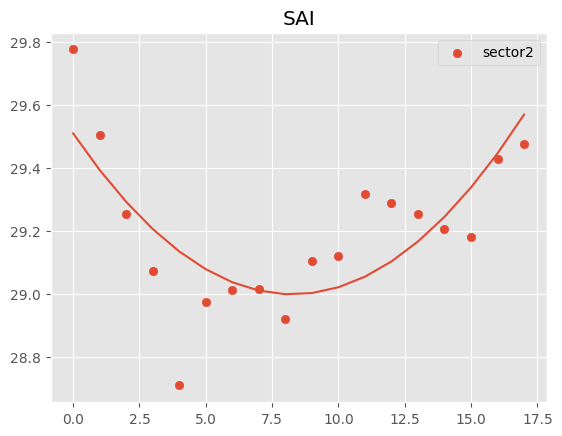

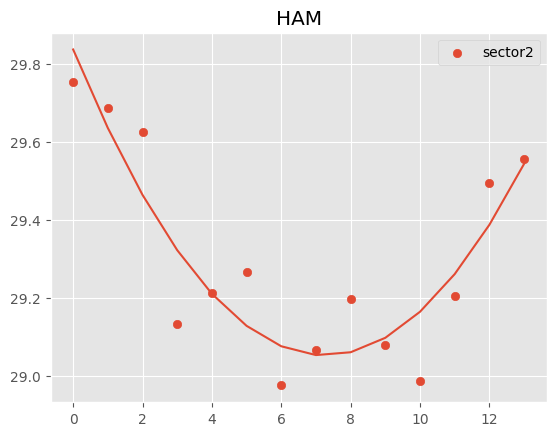

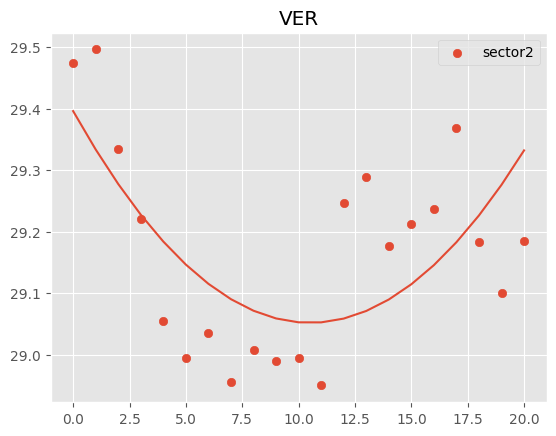

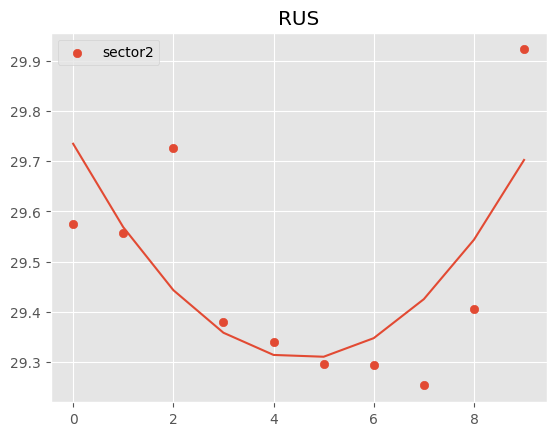

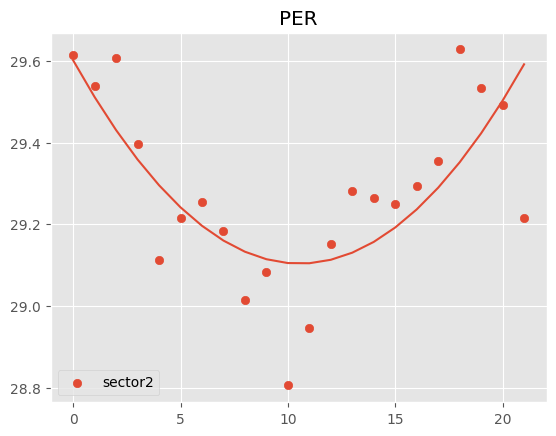

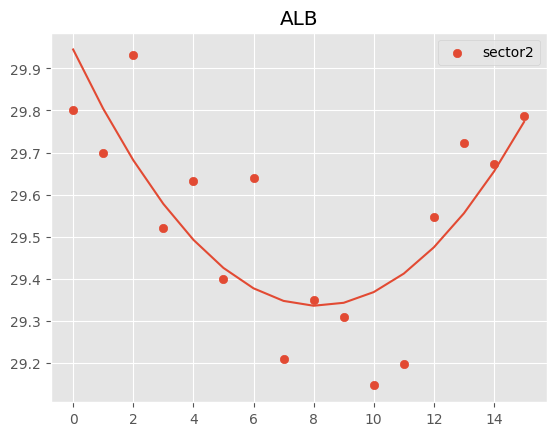

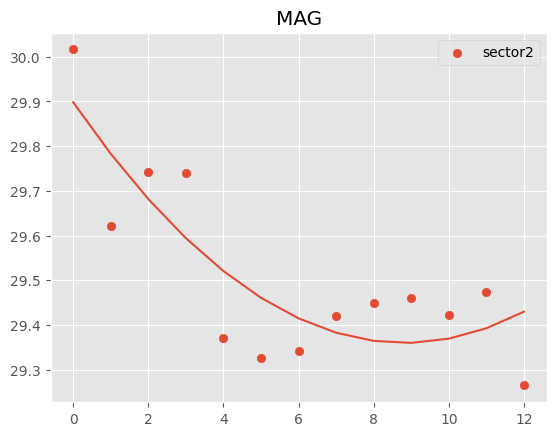

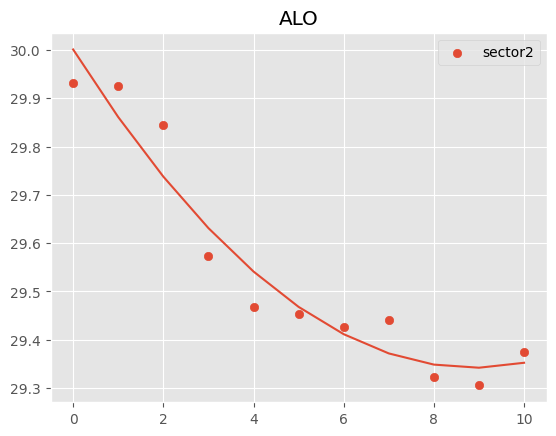

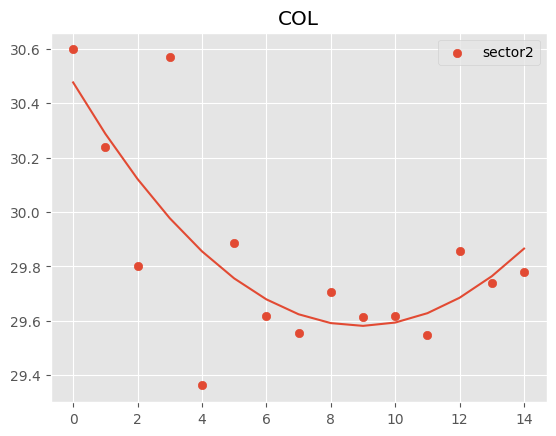

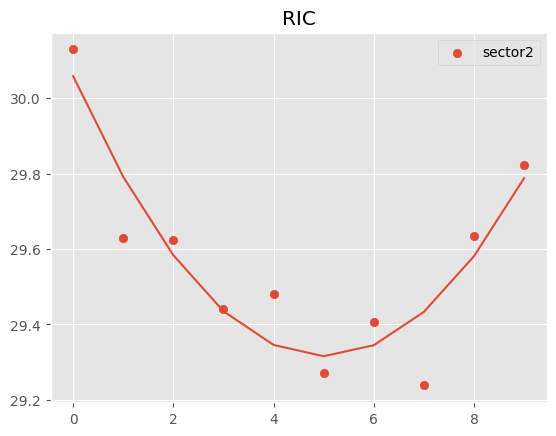

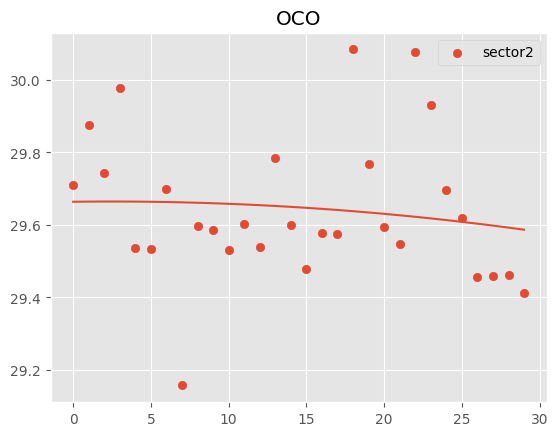

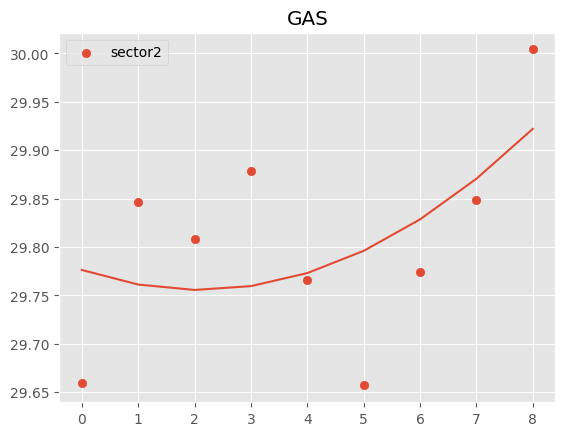

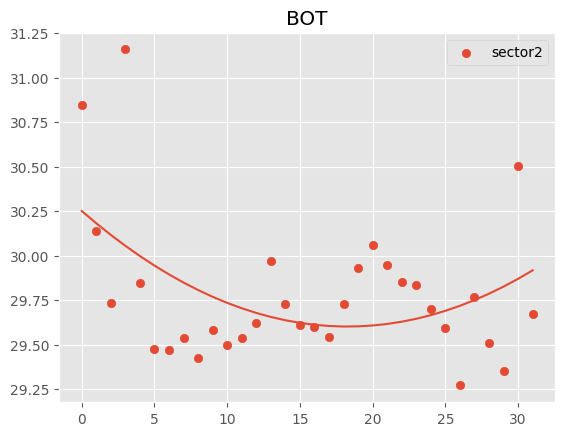

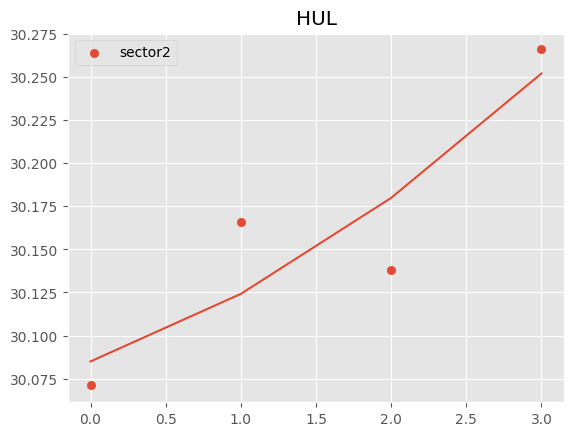

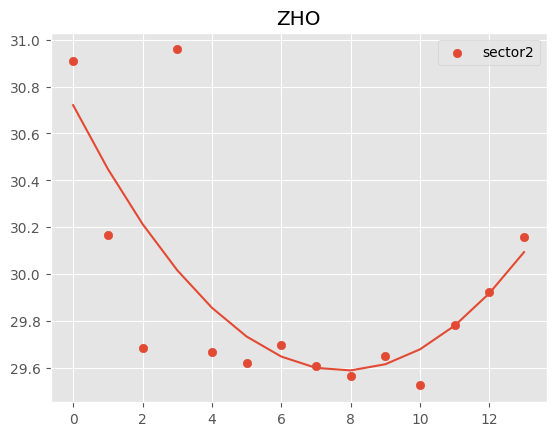

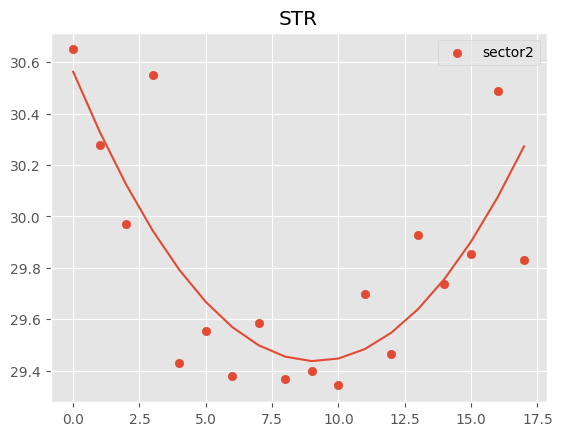

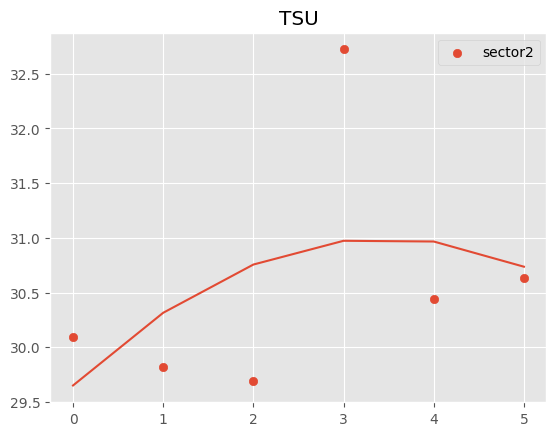

,driver,a,b,c
0,LEC,0.012073,-0.139386,29.174996
1,PIA,0.013101,-0.184452,29.311403
2,NOR,0.009837,-0.150276,29.515132
3,SAI,0.007468,-0.123443,29.509009
4,HAM,0.014917,-0.216528,29.837868
5,VER,0.003113,-0.065453,29.395852
6,RUS,0.020337,-0.186622,29.734991
7,PER,0.004472,-0.094376,29.601432
8,ALB,0.009228,-0.149892,29.944873
9,MAG,0.006918,-0.122016,29.898066


In [18]:
coefficient=[]
for driver in drivers:
    # _,b=plt.subplots()
    markevery=qatar_csv[qatar_csv["Driver"]==driver]["Stint"].value_counts(sort=False).cumsum().to_list()[0]
    # print(driver,markevery)
    sector2Time=qatar_csv.loc[qatar_csv["Driver"]==driver]["Sector2"][1:markevery].to_list()
    x=np.arange(len(sector2Time))
    # print(sector2Time,x)
    polyModel=np.poly1d(np.polyfit(x,sector2Time,2))
    lapCoeff=polyModel.coeffs.tolist()
    lapCoeff.insert(0,driver)
    coefficient.append(lapCoeff)
    _,ax=plt.subplots()
    plt.scatter(x,sector2Time,label="sector2")
    plt.plot(x,polyModel(x))
    plt.title(driver)
    plt.legend()
    plt.show()
# print(coefficient)
coffdb=pd.DataFrame(data=coefficient,columns=["driver","a","b","c"])
coffdb.head(20)

[ 3.11297513e-03 -6.54530090e-02  2.93958521e+01]


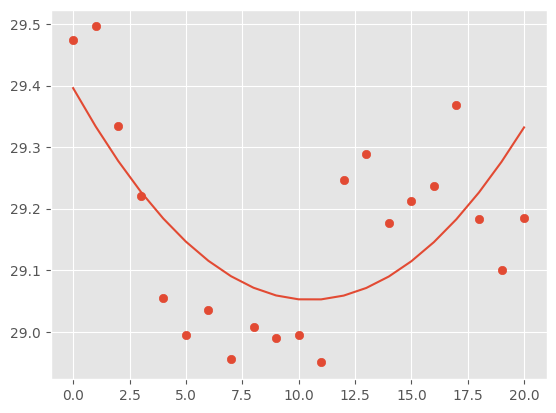

In [19]:
sector2Time=qatar_csv.loc[qatar_csv["Driver"]=="VER"]["Sector2"][1:22].to_list()
x=np.arange(len(sector2Time))
# print(sector2Time,x)
polyModel=np.poly1d(np.polyfit(x,sector2Time,2))
print(polyModel.coeffs)
_,ax=plt.subplots()
plt.scatter(x,sector2Time,label="sector2")
plt.plot(x,polyModel(x))
plt.show()

In [20]:
qatar_csv.loc[:,"Sec1FB"]=qatar_csv.sort_values(["LapNumber","Position"]).groupby("LapNumber")["Sector1"].transform(lambda x: x.diff(periods=-1)>0).sort_index()
qatar_csv.loc[:,"Sec2FB"]=qatar_csv.sort_values(["LapNumber","Position"]).groupby("LapNumber")["Sector2"].transform(lambda x: x.diff(periods=-1)>0).sort_index()
qatar_csv.loc[:,"Sec3FB"]=qatar_csv.sort_values(["LapNumber","Position"]).groupby("LapNumber")["Sector3"].transform(lambda x: x.diff(periods=-1)>0).sort_index()
qatar_csv.loc[:,"Sec1FI"]=qatar_csv.sort_values(["LapNumber","Position"]).groupby("LapNumber")["Sector1"].transform(lambda x: x.diff(periods=1)<0).sort_index()
qatar_csv.loc[:,"Sec2FI"]=qatar_csv.sort_values(["LapNumber","Position"]).groupby("LapNumber")["Sector2"].transform(lambda x: x.diff(periods=1)<0).sort_index()
qatar_csv.loc[:,"Sec3FI"]=qatar_csv.sort_values(["LapNumber","Position"]).groupby("LapNumber")["Sector3"].transform(lambda x: x.diff(periods=1)<0).sort_index()

In [21]:
qatar_csv.columns
qatar_csv.drop(columns=["Driver","PitOutTime","PitInTime","Sector1SessionTime","Sector2SessionTime","Sector3SessionTime","SpeedI1","SpeedI2","SpeedFL","SpeedST","FreshTyre","LapStartTime","LapStartDate","FastF1Generated","IsAccurate","DeletedReason"], inplace=True)
qatar_csv.columns

Index(['Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'Sector1Time',
       'Sector2Time', 'Sector3Time', 'IsPersonalBest', 'Compound', 'TyreLife',
       'Team', 'TrackStatus', 'Position', 'Deleted', 'Sector1', 'Sector2',
       'Sector3', 'Sec1FB', 'Sec2FB', 'Sec3FB', 'Sec1FI', 'Sec2FI', 'Sec3FI'],
      dtype='object')

In [46]:
qatar_csv["IsPersonalBest"]=~qatar_csv["IsPersonalBest"]
qatar_csv.query("DriverNumber==81")["IsPersonalBest"].groupby((~qatar_csv["IsPersonalBest"]).cumsum()).cumsum()


53      1
54      0
55      1
56      0
57      0
58      0
59      0
60      1
61      0
62      0
63      1
64      2
65      3
66      4
67      5
68      6
69      7
70      0
71      1
72      0
73      0
74      0
75      1
76      0
77      0
78      0
79      0
80      1
81      0
82      0
83      1
84      2
85      3
86      4
87      5
88      6
89      7
90      8
91      9
92      0
93      0
94      1
95      2
96      3
97      4
98      5
99      6
100     7
101     8
102     9
103    10
104     0
105     0
Name: IsPersonalBest, dtype: int64

In [29]:
def func(x):
    print(x.name)
qatar_csv.query("DriverNumber==81").groupby("IsPersonalBest").apply(func)




False
True


C:\Users\amanh\AppData\Local\Temp\ipykernel_45588\1097316257.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qatar_csv.query("DriverNumber==81").groupby("IsPersonalBest").apply(func)


""


In [23]:
f1.get_event_schedule(2024, include_testing=False)
grand_prix_list = [
    "Bahrain Grand Prix",
    "Saudi Arabian Grand Prix",
    "Australian Grand Prix",
    "Chinese Grand Prix",
    "Miami Grand Prix",
    "Spanish Grand Prix",
    "Austrian Grand Prix",
    "British Grand Prix",
    "Hungarian Grand Prix",
    "Belgian Grand Prix",
    "Dutch Grand Prix",
    "Italian Grand Prix",
    "Singapore Grand Prix",
    "United States Grand Prix (Austin)",
    "Mexican Grand Prix",
    "Las Vegas Grand Prix",
    "Qatar Grand Prix",
    "Abu Dhabi Grand Prix"
]

In [24]:
f1.Cache.clear_cache("D:\\Aman\\f1_analytics\\cache")